In [ ]:
#@title Allowed Resources
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Wed Jan 26 10:29:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [ ]:
!pip install ruclip==0.0.1 > /dev/null

In [ ]:
import os
import torch
import ruclip
import random
import numpy as np
import skimage
from glob import glob
from tqdm.auto import tqdm
from torchvision.datasets import CIFAR10, CIFAR100
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [ ]:
f"All models: {list(ruclip.MODELS.keys())}"

"All models: ['ruclip-vit-base-patch32-224', 'ruclip-vit-base-patch16-224', 'ruclip-vit-large-patch14-224', 'ruclip-vit-large-patch14-336', 'ruclip-vit-base-patch32-384', 'ruclip-vit-base-patch16-384']"

In [ ]:
device = 'cuda'
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

### Prediction [Minimal Example]

8it [00:00, 46.76it/s]


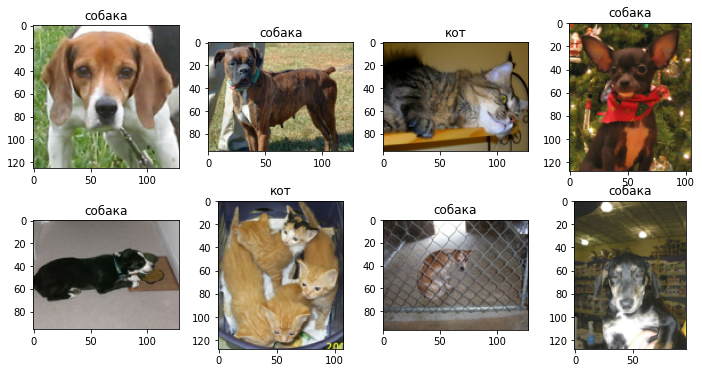

In [ ]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random

classes = ['кот', 'собака']
templates = ['{}', 'это {}', 'на картинке {}', 'это {}, домашнее животное']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

bs4_urls = requests.get('https://raw.githubusercontent.com/sberbank-ai/ru-dolph/master/pics/pipelines/cats_vs_dogs_bs4.json').json()
pil_images = [Image.open(BytesIO(base64.b64decode(bs4_url))) for bs4_url in bs4_urls]

with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    pred_labels = predictor.run(pil_images, text_latents)

f, ax = plt.subplots(2,4, figsize=(12,6))
for i, (pil_img, pred_label) in enumerate(zip(pil_images, pred_labels)):
    ax[i//4, i%4].imshow(pil_img)
    ax[i//4, i%4].set_title(classes[pred_label])

# Calculating cosine similarity

8it [00:00, 65.77it/s]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

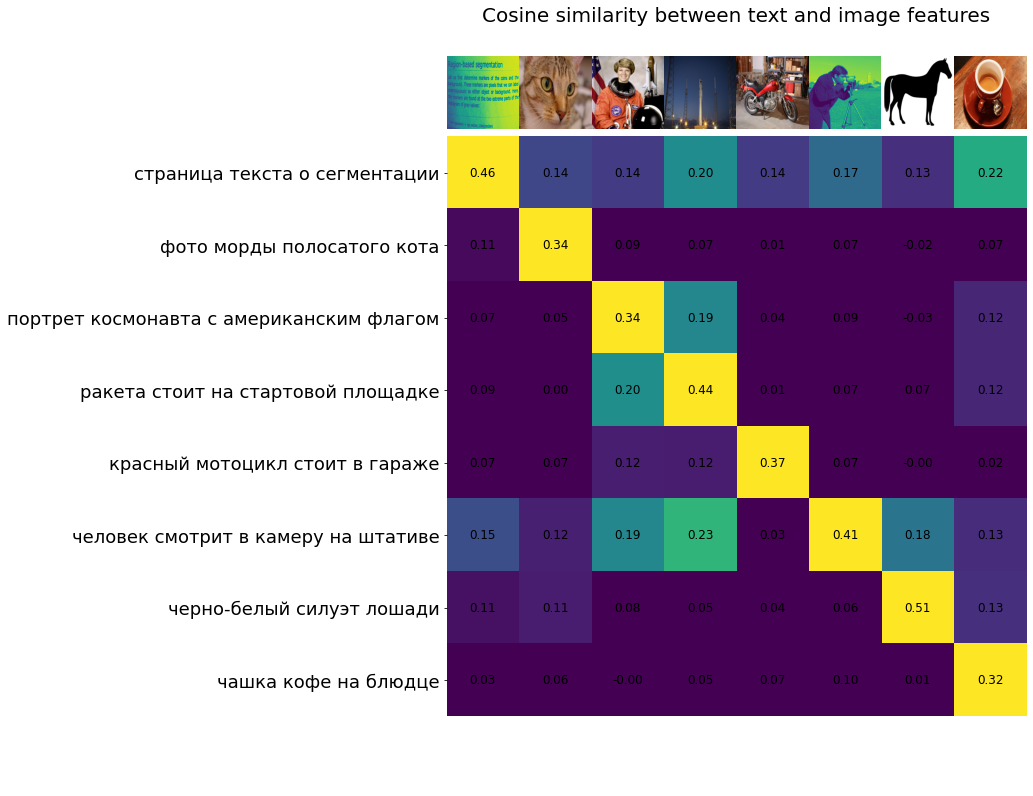

In [ ]:
descriptions = {
    'page.png': 'страница текста о сегментации',
    'chelsea.png': 'фото морды полосатого кота',
    'astronaut.png': 'портрет космонавта с американским флагом',
    'rocket.jpg': 'ракета стоит на стартовой площадке',
    'motorcycle_right.png': 'красный мотоцикл стоит в гараже',
    'camera.png': 'человек смотрит в камеру на штативе',
    'horse.png': 'черно-белый силуэт лошади',
    'coffee.png': 'чашка кофе на блюдце'
}

templates = ['{}', 'это {}']
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)

classes = list(descriptions.values())
pil_images = [Image.open(f'{skimage.data_dir}/{image_name}') for image_name in descriptions]

with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    image_latents = predictor.get_image_latents(pil_images)
    logits_per_text = torch.matmul(text_latents, image_latents.t())
    logits_per_image = logits_per_text.t()

count = len(classes)
similarity = logits_per_image.cpu().numpy()

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), classes, fontsize=18)
plt.xticks([])

for i, pil_img in enumerate(pil_images):
    plt.imshow(pil_img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

for side in ['left', 'top', 'right', 'bottom']:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
plt.title('Cosine similarity between text and image features', size=20)

### Evaluate ZS-CLF CIFAR100

In [ ]:
classes = ['яблоко', 'аквариумные рыбки', 'младенец', 'медведь', 'бобр', 'кровать', 'пчела', 'жук', 'велосипед', 'бутылка', 'чаша', 'мальчик', 'мост', 'автобус', 'бабочка', 'верблюд', 'мочь', 'замок', 'гусеница', 'крупный рогатый скот', 'стул', 'шимпанзе', 'часы', 'облако', 'таракан', 'диван', 'краб', 'крокодил', 'чашка', 'динозавр', 'дельфин', 'слон', 'камбала', 'лес', 'лиса', 'девочка', 'хомяк', 'дом', 'кенгуру', 'клавиатура', 'лампа', 'газонокосилка', 'леопард', 'лев', 'ящерица', 'лобстер', 'мужчина', 'кленовое дерево', 'мотоцикл', 'гора', 'мышь', 'гриб', 'дубовое дерево', 'оранжевый', 'орхидея', 'выдра', 'пальма', 'груша', 'пикап', 'сосна', 'простой', 'тарелка', 'мак', 'дикобраз', 'опоссум', 'кролик', 'енот', 'луч', 'дорога', 'ракета', 'роза', 'море', 'печать', 'акула', 'землеройка', 'скунс', 'небоскреб', 'улитка', 'змея', 'паук', 'белка', 'трамвай', 'подсолнух', 'сладкий перец', 'стол', 'бак', 'телефон', 'телевидение', 'тигр', 'трактор', 'поезд', 'форель', 'тюльпан', 'черепаха', 'гардероб', 'кит', 'ива', 'волк', 'женщина', 'червь']
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
predictor = ruclip.Predictor(clip, processor, device, bs=16, templates=None)

In [ ]:
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    images = (pil_img for pil_img, _ in cifar100)
    pred_labels = predictor.run(images, text_latents)
    zs_accuracy = np.mean((np.array(pred_labels) == np.array(cifar100.targets)).astype(np.float)) * 100.
    print(f"Accuracy = {zs_accuracy:.3f}")

10000it [02:23, 69.69it/s]

Accuracy = 52.880


In [ ]:
print(classification_report(np.array(cifar100.targets), np.array(pred_labels), target_names=classes))

                      precision    recall  f1-score   support

              яблоко       0.59      0.95      0.73       100
   аквариумные рыбки       0.81      0.48      0.60       100
            младенец       0.67      0.51      0.58       100
             медведь       0.50      0.66      0.57       100
                бобр       0.41      0.16      0.23       100
             кровать       0.90      0.70      0.79       100
               пчела       0.28      0.84      0.42       100
                 жук       0.56      0.42      0.48       100
           велосипед       0.95      0.81      0.88       100
             бутылка       0.72      0.81      0.76       100
                чаша       0.49      0.30      0.37       100
             мальчик       0.57      0.69      0.63       100
                мост       0.97      0.63      0.76       100
             автобус       0.68      0.67      0.67       100
             бабочка       1.00      0.47      0.64       100
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Softmax Scores Visualization

8it [00:00, 146.04it/s]


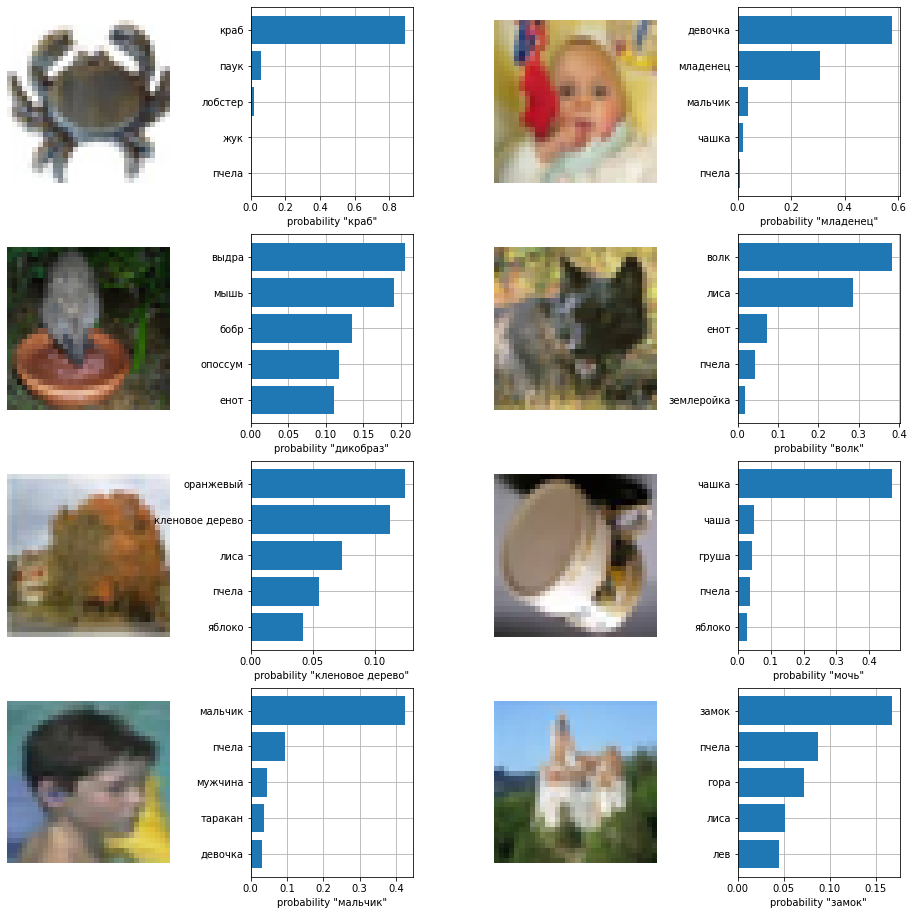

In [ ]:
pil_images = []
labels = []
for pil_img, label in random.choices(cifar100, k=8):
    pil_images.append(pil_img)
    labels.append(label)

with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    image_latents = predictor.get_image_latents(pil_images)
    logits_per_text = torch.matmul(text_latents, image_latents.t())
    logits_per_image = logits_per_text.t()
    text_probs = (logits_per_image * clip.logit_scale.exp()).softmax(dim=-1)
    top_probs, top_labels = text_probs.detach().cpu().topk(5, dim=-1)


plt.figure(figsize=(16, 16))
for i, image in enumerate(pil_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    plt.xlabel(f'probability "{classes[labels[i]]}"')

plt.subplots_adjust(wspace=0.5)
plt.show()

# Linear Probe

In [ ]:
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True)
test = CIFAR100(root, download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
with torch.no_grad():
    X_train = predictor.get_image_latents((pil_img for pil_img, _ in train)).cpu().numpy()
    X_test = predictor.get_image_latents((pil_img for pil_img, _ in test)).cpu().numpy()
    y_train, y_test = np.array(train.targets), np.array(test.targets)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

50000it [08:44, 95.34it/s]
10000it [01:46, 94.04it/s]


(((50000, 512), (50000,)), ((10000, 512), (10000,)))

In [ ]:
%%time

clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 2min 21s, sys: 37.5 s, total: 2min 59s
Wall time: 1min 38s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


In [ ]:
y_pred = clf.predict(X_test)
accuracy = np.mean((y_test == y_pred).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 75.680


In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

                      precision    recall  f1-score   support

              яблоко       0.91      0.96      0.94       100
   аквариумные рыбки       0.79      0.89      0.84       100
            младенец       0.76      0.71      0.74       100
             медведь       0.69      0.61      0.65       100
                бобр       0.42      0.47      0.45       100
             кровать       0.88      0.81      0.84       100
               пчела       0.82      0.76      0.79       100
                 жук       0.76      0.73      0.74       100
           велосипед       0.93      0.86      0.90       100
             бутылка       0.96      0.92      0.94       100
                чаша       0.62      0.66      0.64       100
             мальчик       0.65      0.68      0.67       100
                мост       0.89      0.85      0.87       100
             автобус       0.80      0.78      0.79       100
             бабочка       0.79      0.72      0.75       100
       

### linear-prob using n-shots of classes

In [ ]:
label2indices = {}

for idx, label in enumerate(y_train):
  if label in label2indices:
    label2indices[label].append(idx)
  else:
    label2indices[label] = [idx]

In [ ]:
def get_images_for_classes(label2indices, num_images=1):
    indices = []

    for label in label2indices:
        label_indices = np.random.choice(label2indices[label], num_images, replace=False)
        indices.extend(label_indices)

    return indices

In [ ]:
indices = get_images_for_classes(label2indices)

In [ ]:
num_images_list = [1, 2, 4, 8, 16]
accuracy_list = []

for num_images in tqdm(num_images_list):
    indices = get_images_for_classes(label2indices, num_images=num_images)

    clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, verbose=1)
    clf.fit(X_train[indices], y_train[indices])

    y_pred = clf.predict(X_test)
    accuracy_nshot = np.mean((y_test == y_pred).astype(np.float)) * 100.

    print(f"Accuracy for {num_images} images for 1 class = {accuracy_nshot:.3f}")

    accuracy_list.append(accuracy_nshot/100)

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Accuracy for 1 images for 1 class = 28.060


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Accuracy for 2 images for 1 class = 35.750


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy for 4 images for 1 class = 42.750


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy for 8 images for 1 class = 50.570
Accuracy for 16 images for 1 class = 59.110


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


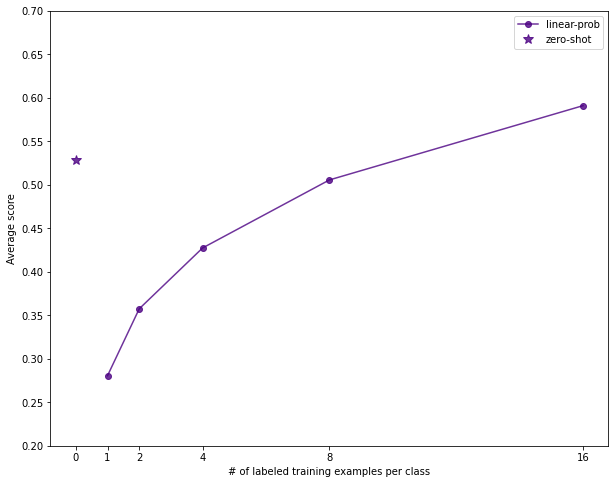

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot([1, 2, 4, 8, 16], accuracy_list, '-o', color='indigo', label='linear-prob', alpha=0.8,)
plt.plot(0, zs_accuracy/100, "*", color='indigo', markersize=10, alpha=0.8, label='zero-shot')

plt.legend()
plt.xlabel("# of labeled training examples per class")
plt.ylabel("Average score")
plt.yticks(np.linspace(0.2, 0.7, 11));
plt.xticks([0, 1, 2, 4, 8, 16]);